## Imports

In [3]:
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from scipy.stats import randint

from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

## Load In Data & Clean
1. Drop unwanted Columns
2. Take a sample of the whole dataset to train and test
3. Convert data of VisitorType column to numeric type
4. Standardize dataframe

In [5]:
df = pd.read_csv('online_shoppers_intention.csv')
df = df.drop(['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration', 'Month', 'OperatingSystems', 'Browser', 'Region', 'TrafficType'], axis=1)
df = df.sample(frac=0.4)
df = df.reset_index()
# for i in range(len(df)):
#     if df.loc[i, 'VisitorType'] == 'Returning_Visitor':
#         df.loc[i, 'VisitorType'] = 1
#     else:
#         df.loc[i, 'VisitorType'] = 0
df['VisitorType'] = df['VisitorType'].map({'Returning_Visitor':1, 'New_Visitor':0})
cols_to_norm = ['ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay']
df[cols_to_norm] = StandardScaler().fit_transform(df[cols_to_norm])
df.head()

,index,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,VisitorType,Weekend,Revenue
0,3937,1.613681,0.931767,-0.442174,-0.686272,-0.319970,-0.307994,1.0,False,False
1,1837,-0.017618,0.046944,-0.443665,-0.443186,0.036783,-0.307994,1.0,False,False
2,257,-0.604886,0.081760,-0.454953,-0.473968,-0.319970,-0.307994,1.0,False,False
3,11660,0.004132,-0.244127,-0.208686,-0.273629,0.197097,-0.307994,1.0,True,False
4,7606,1.113416,1.358907,-0.448042,-0.714821,0.688847,-0.307994,1.0,False,True


In [6]:
print(df.shape)
df.describe()

(4932, 10)


,index,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,VisitorType
count,4932.000000,4.932000e+03,4.932000e+03,4.932000e+03,4.932000e+03,4.932000e+03,4.932000e+03,4895.000000
mean,6181.615166,1.728814e-17,1.102119e-16,-5.258477e-17,-9.742590e-17,5.042375e-18,3.133476e-17,0.853320
std,3559.429025,1.000101e+00,1.000101e+00,1.000101e+00,1.000101e+00,1.000101e+00,1.000101e+00,0.353823
min,0.000000,-6.918886e-01,-5.732362e-01,-4.549525e-01,-8.813811e-01,-3.199695e-01,-3.079944e-01,0.000000
25%,3139.250000,-5.396341e-01,-4.911878e-01,-4.549525e-01,-5.903717e-01,-3.199695e-01,-3.079944e-01,1.000000
50%,6186.500000,-3.003769e-01,-2.950663e-01,-3.933858e-01,-3.721147e-01,-3.199695e-01,-3.079944e-01,1.000000
75%,9220.000000,1.128855e-01,1.128787e-01,-1.163355e-01,1.371516e-01,-3.199695e-01,-3.079944e-01,1.000000
max,12329.000000,1.464232e+01,2.992900e+01,3.608452e+00,3.192750e+00,1.823964e+01,4.715247e+00,1.000000


## Split Data Into Training and Testing

In [8]:
target = df.pop('Revenue')
x_train, x_test, y_train, y_test = train_test_split(df, target, test_size=0.2, random_state=1)

## Fit Data to Model
Random Forest Model used because of multiple variables contributing to binary classification

In [10]:
random_forest = RandomForestClassifier()
random_forest.fit(x_train, y_train)
rf_prediction = random_forest.predict(x_test)
rf_accuracy = accuracy_score(rf_prediction, y_test)
rf_precision = precision_score(rf_prediction, y_test)
rf_recall = recall_score(rf_prediction, y_test)

In [11]:
print(f'Accuracy of random forest: {rf_accuracy}')
print(f'Precision of random forest: {rf_precision}')
print(f'Recall of random forest: {rf_recall}')

Accuracy of random forest: 0.9027355623100304
Precision of random forest: 0.5611510791366906
Recall of random forest: 0.6902654867256637


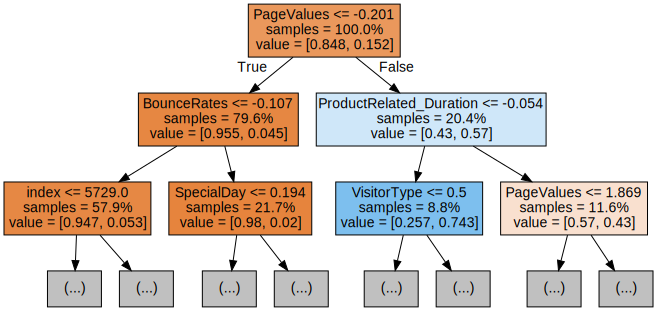

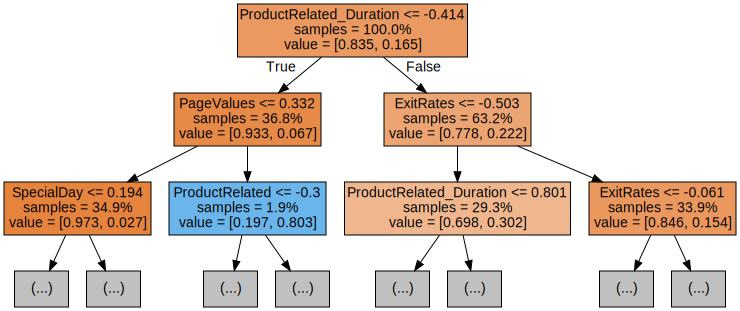

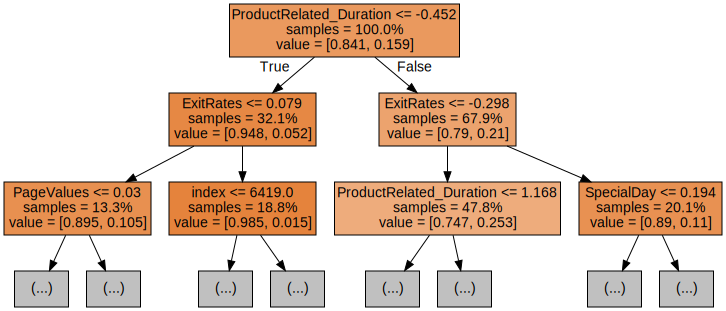

In [12]:
for i in range(3):
    tree = random_forest.estimators_[i]
    dot_data = export_graphviz(tree,
                              feature_names=x_train.columns,
                              filled=True,
                              max_depth=2,
                              impurity=False,
                              proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)

## Find Best Hyperparameters
Tune the hyperparameters of the random forest model (number of estimators and tree depth) in order to improve the performance of the model

In [14]:
param_dist = {'n_estimators': randint(50, 500),
             'max_depth': randint(1, 20)}

param_rf = RandomForestClassifier()
rand_search = RandomizedSearchCV(param_rf,
                                param_distributions = param_dist,
                                n_iter=5,
                                cv=5)
rand_search.fit(x_train,y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=5,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x3037cfb30>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x3037cfb60>})

In [15]:
best_rf = rand_search.best_estimator_
print(f'Best hyperparameters: {rand_search.best_params_}')

Best hyperparameters: {'max_depth': 5, 'n_estimators': 270}


## Evaluate Performance of the Enhanced Model

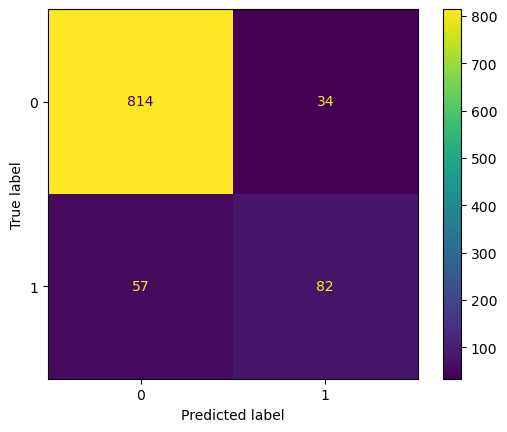

In [17]:
best_prediction = best_rf.predict(x_test)
cm = confusion_matrix(y_test, best_prediction)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

In [18]:
accuracy = accuracy_score(y_test, best_prediction)
precision = precision_score(y_test, best_prediction)
recall = recall_score(y_test, best_prediction)

print(f'Accuracy of random forest: {accuracy}')
print(f'Precision of random forest: {precision}')
print(f'Recall of random forest: {recall}')

Accuracy of random forest: 0.9078014184397163
Precision of random forest: 0.7068965517241379
Recall of random forest: 0.5899280575539568


## Determine Most Important Variables Contributing Classification Outcome

<Axes: >

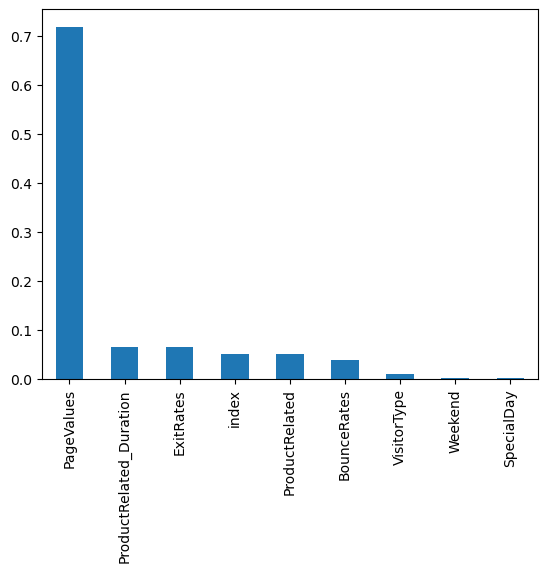

In [20]:
feature_importance = pd.Series(best_rf.feature_importances_, index=x_train.columns).sort_values(ascending=False)
feature_importance.plot.bar()